In [1]:
#library(susieR)
set.seed(1)
suppressMessages(library(tidyverse))
library('metap')

Warning message:
"package 'tidyverse' was built under R version 4.2.1"
Warning message:
"package 'tibble' was built under R version 4.2.1"
Warning message:
"package 'tidyr' was built under R version 4.2.1"
Warning message:
"package 'dplyr' was built under R version 4.2.1"
Warning message:
"package 'stringr' was built under R version 4.2.1"
Warning message:
"package 'forcats' was built under R version 4.2.1"
Warning message:
"package 'metap' was built under R version 4.2.1"


In [2]:
META_THREE <- read.table(gzfile("../data/TRANSANCESTRY_GWAS_ALLELECORRECTED.TAB"),header=T,fill=TRUE,row.names=NULL)

In [3]:
finemap <- read.table("../../ANALYSIS//FINEMAP/TRANS_FINEMAP_PIP.tab",fill=TRUE,row.names=NULL,header=FALSE)
colnames(finemap) <- c("MARKERNAME","FINEMAP_PIP")
susie <- read.table("../../ANALYSIS/SUSIE//trans_susie_pip.tab",fill=TRUE,row.names=NULL,header=TRUE)

In [4]:
### plot

In [5]:
#finemap

In [6]:
df_1 <- read.table("../../ANALYSIS/META/TRANSANCESTRY_RESULTS.TAB",header=T)%>%select(MARKERNAME,CHROMOSOME,POSITION,BETA_FE,STD_FE,PVALUE_FE,MAF_AVG)
annot_1 <- read.table("../../ANALYSIS/3way_lead.txt",header=T)
df_3way <- merge(df_1,annot_1,by="MARKERNAME",all.x=TRUE)%>%select(MARKERNAME,CHROMOSOME,POSITION)
finemap_df <- merge(df_3way,finemap,by="MARKERNAME",all.x = TRUE)%>%mutate(FINEMAP_PIP = replace_na(FINEMAP_PIP, -0.1))%>%
mutate(size=case_when(FINEMAP_PIP > 0.9  ~ "3",TRUE ~ "2"))

In [7]:
head(finemap_df,2)

,MARKERNAME,CHROMOSOME,POSITION,FINEMAP_PIP,size
,<chr>,<int>,<int>,<dbl>,<chr>
1,rs10000081,4,17348363,-0.1,2
2,rs10000092,4,21895517,-0.1,2


In [8]:
plot_df <- finemap_df %>% 
  group_by(CHROMOSOME) %>% 
  # Compute chromosome size
  summarise(chrlength = max(POSITION)) %>%  
  # Calculate cumulative position of each chromosome
  mutate(cumulativechrlength = cumsum(as.numeric(chrlength))-chrlength) %>% 
  select(-chrlength) %>%
  # Temporarily add the cumulative length of each chromosome to the initial 
  # dataset 
  left_join(finemap_df, ., by=c("CHROMOSOME"="CHROMOSOME")) %>%
  # Sort by chr then position 
  arrange(CHROMOSOME, POSITION) %>%
  # Add the position to the cumulative chromosome length to get the position of 
  # this probe relative to all other probes
  mutate(rel_pos = POSITION + cumulativechrlength)

axis_df <- plot_df %>% 
  group_by(CHROMOSOME) %>% 
  summarize(chr_center=(max(rel_pos) + min(rel_pos)) / 2)
maxp <- ceiling(max(plot_df$FINEMAP_PIP, na.rm = TRUE))

plot_df <- plot_df%>%filter(FINEMAP_PIP>=0)

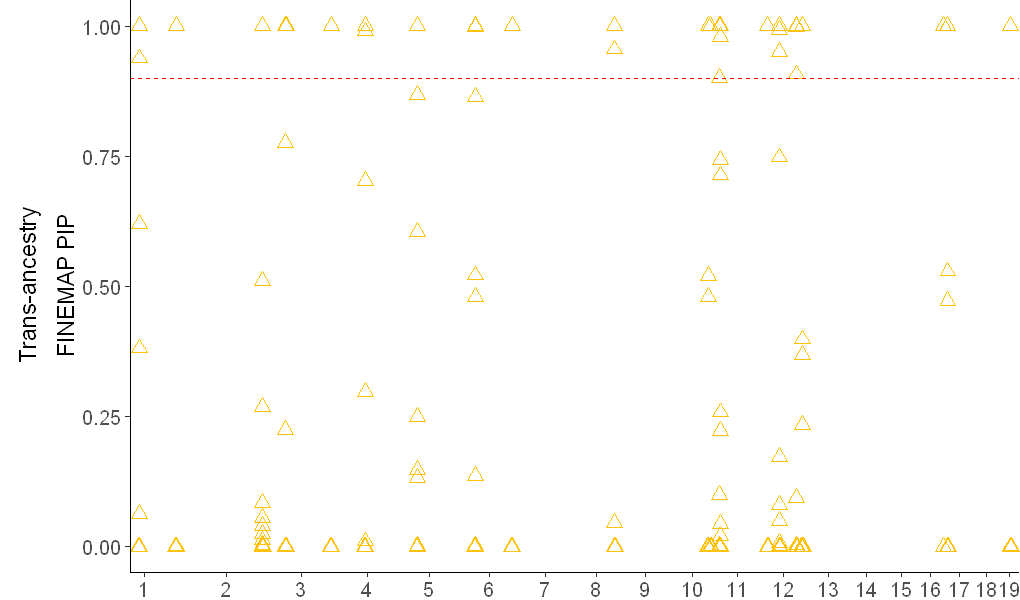

In [9]:
options(repr.plot.width=8.5, repr.plot.height=5)
b = c(0,0.20,0.60,0.8,0.9,1)
 p1 <- ggplot() + 
  geom_point(data =  plot_df, 
             aes(x = rel_pos, y = FINEMAP_PIP),size=3, color = "#FFC20A",shape=24)+scale_x_continuous(labels = axis_df$CHROMOSOME, 
                     breaks = axis_df$chr_center, 
                     expand = expansion(mult = 0.01))+ 
#scale_y_sqrt(breaks=b,labels=b,limits = c(0,1),expand = expansion(mult = c(0.01, 0)))+
geom_hline(yintercept = 0.9, color = "red", linetype = "dashed", size = 0.3)+
labs(x = "", y = bquote(atop('Trans-ancestry', 'FINEMAP PIP'))) + theme_classic() + theme(legend.position = "none", axis.title.x = element_blank(),plot.margin = margin(b = 0, l = 10))+
theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))
p1

In [10]:
## susie

In [11]:
susie_df <- merge(df_3way,susie,by="MARKERNAME",all.x = TRUE)%>%mutate(SUSIE_PIP = replace_na(SUSIE_PIP, -0.1))%>%
mutate(size=case_when(SUSIE_PIP > 0.9  ~ "0.6",TRUE ~ "0.4"))

In [12]:
plot_df <- susie_df %>% 
  group_by(CHROMOSOME) %>% 
  # Compute chromosome size
  summarise(chrlength = max(POSITION)) %>%  
  # Calculate cumulative position of each chromosome
  mutate(cumulativechrlength = cumsum(as.numeric(chrlength))-chrlength) %>% 
  select(-chrlength) %>%
  # Temporarily add the cumulative length of each chromosome to the initial 
  # dataset 
  left_join(susie_df, ., by=c("CHROMOSOME"="CHROMOSOME")) %>%
  # Sort by chr then position 
  arrange(CHROMOSOME, POSITION) %>%
  # Add the position to the cumulative chromosome length to get the position of 
  # this probe relative to all other probes
  mutate(rel_pos = POSITION + cumulativechrlength)

axis_df <- plot_df %>% 
  group_by(CHROMOSOME) %>% 
  summarize(chr_center=(max(rel_pos) + min(rel_pos)) / 2)
#maxp <- ceiling(max(plot_df$SUSIE_PIP, na.rm = TRUE))

plot_df <- plot_df%>%filter(SUSIE_PIP>=0)

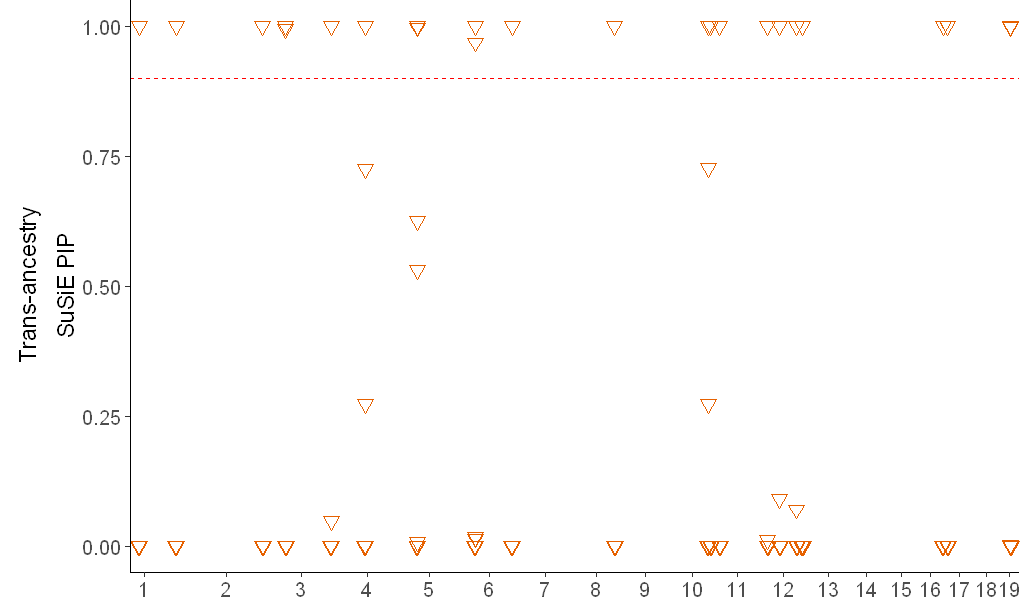

In [13]:
options(repr.plot.width=8.5, repr.plot.height=5)
#b = c(0,0.20,0.60,0.8,0.9,1)
 p2 <- ggplot() + 
  geom_point(data =  plot_df, 
             aes(x = rel_pos, y = SUSIE_PIP),size=3,color = "#E66100",shape=25)+scale_x_continuous(labels = axis_df$CHROMOSOME, 
                     breaks = axis_df$chr_center, 
                     expand = expansion(mult = 0.01))+ 
#scale_y_sqrt(breaks=b,labels=b,limits = c(0,1),expand = expansion(mult = c(0.01, 0)))+
geom_hline(yintercept = 0.9, color = "red", linetype = "dashed", size = 0.3)+
labs(x = "", y = bquote(atop('Trans-ancestry', 'SuSiE PIP'))) + theme_classic() + theme(legend.position = "none", axis.title.x = element_blank(),plot.margin = margin(b = 0, l = 10))+
theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))
p2

Warning message:
"package 'ggpubr' was built under R version 4.2.1"
Warning message:
"package 'gridExtra' was built under R version 4.2.1"

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




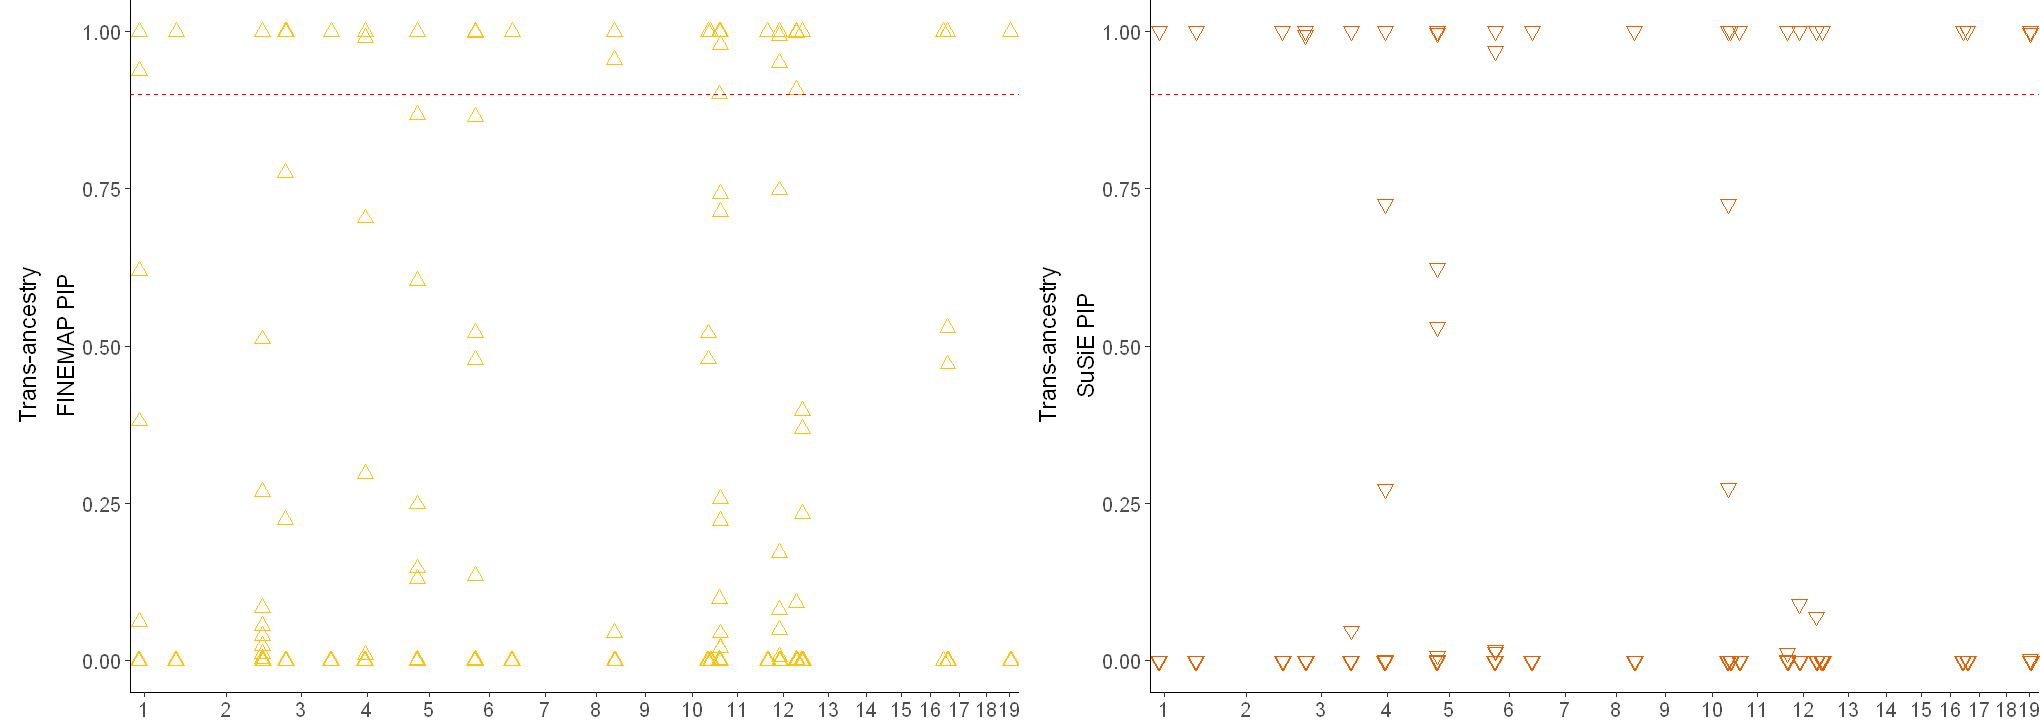

In [14]:
library('ggpubr')
library('gridExtra')
options(repr.plot.width=17, repr.plot.height=6)
p <- gridExtra::grid.arrange(p1,p2,ncol=2,widths= c(0.5,0.5))
ggsave(filename = "../../ANALYSIS/PAPER/Figures/Supplementary/SuppFig4.pdf", device = "pdf",  plot = p, width = 17, height =6 , dpi = 1200, units = "in")

In [15]:
##average

In [16]:
result_df <- merge(finemap,susie,by="MARKERNAME")%>%mutate(AVG_PIP=(FINEMAP_PIP+SUSIE_PIP)/2)
avg_df <- merge(df_3way,result_df,by="MARKERNAME",all.x = TRUE)%>%mutate(AVG_PIP = replace_na(AVG_PIP, -0.1))

In [17]:
snp_ld <- read.table("../../ANALYSIS/PAPER/Figures/Main/snp_ld.txt",header=T)
avg_df <- merge(avg_df,snp_ld,by="MARKERNAME",all.x=TRUE)

In [18]:
plot_df <- avg_df %>% 
  group_by(CHROMOSOME) %>% 
  # Compute chromosome size
  summarise(chrlength = max(POSITION)) %>%  
  # Calculate cumulative position of each chromosome
  mutate(cumulativechrlength = cumsum(as.numeric(chrlength))-chrlength) %>% 
  select(-chrlength) %>%
  # Temporarily add the cumulative length of each chromosome to the initial 
  # dataset 
  left_join(avg_df, ., by=c("CHROMOSOME"="CHROMOSOME")) %>%
  # Sort by chr then position 
  arrange(CHROMOSOME, POSITION) %>%
  # Add the position to the cumulative chromosome length to get the position of 
  # this probe relative to all other probes
  mutate(rel_pos = POSITION + cumulativechrlength)%>%
mutate(color=case_when(LD==1 ~"Index",LD>=0.8 & LD<1 ~"0.8-1",
                        LD>=0.6 & LD<0.8  ~"0.6-0.8",LD>=0.3 & LD<0.6  ~"0.3-0.6",LD>0 & LD<0.3  ~"0-0.3",TRUE ~ "ns"))
axis_df <- plot_df %>% 
  group_by(CHROMOSOME) %>% 
  summarize(chr_center=(max(rel_pos) + min(rel_pos)) / 2)
#maxp <- ceiling(max(plot_df$SUSIE_PIP, na.rm = TRUE))

plot_df <- plot_df%>%filter(AVG_PIP>=0)

In [19]:
plot_df%>%filter(LD==1)

MARKERNAME,CHROMOSOME,POSITION,FINEMAP_PIP,SUSIE_PIP,AVG_PIP,LD,cumulativechrlength,rel_pos,color
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
rs2061155,1,219665008,1,1,1,1,0,219665008,Index
rs1108842,3,52720080,1,1,1,1,491074016,543794096,Index
rs10886863,10,122929493,1,1,1,1,1677502885,1800432378,Index
rs7978610,12,124468572,1,1,1,1,1947819873,2072288445,Index
rs731839,19,33899065,1,1,1,1,2653505558,2687404623,Index


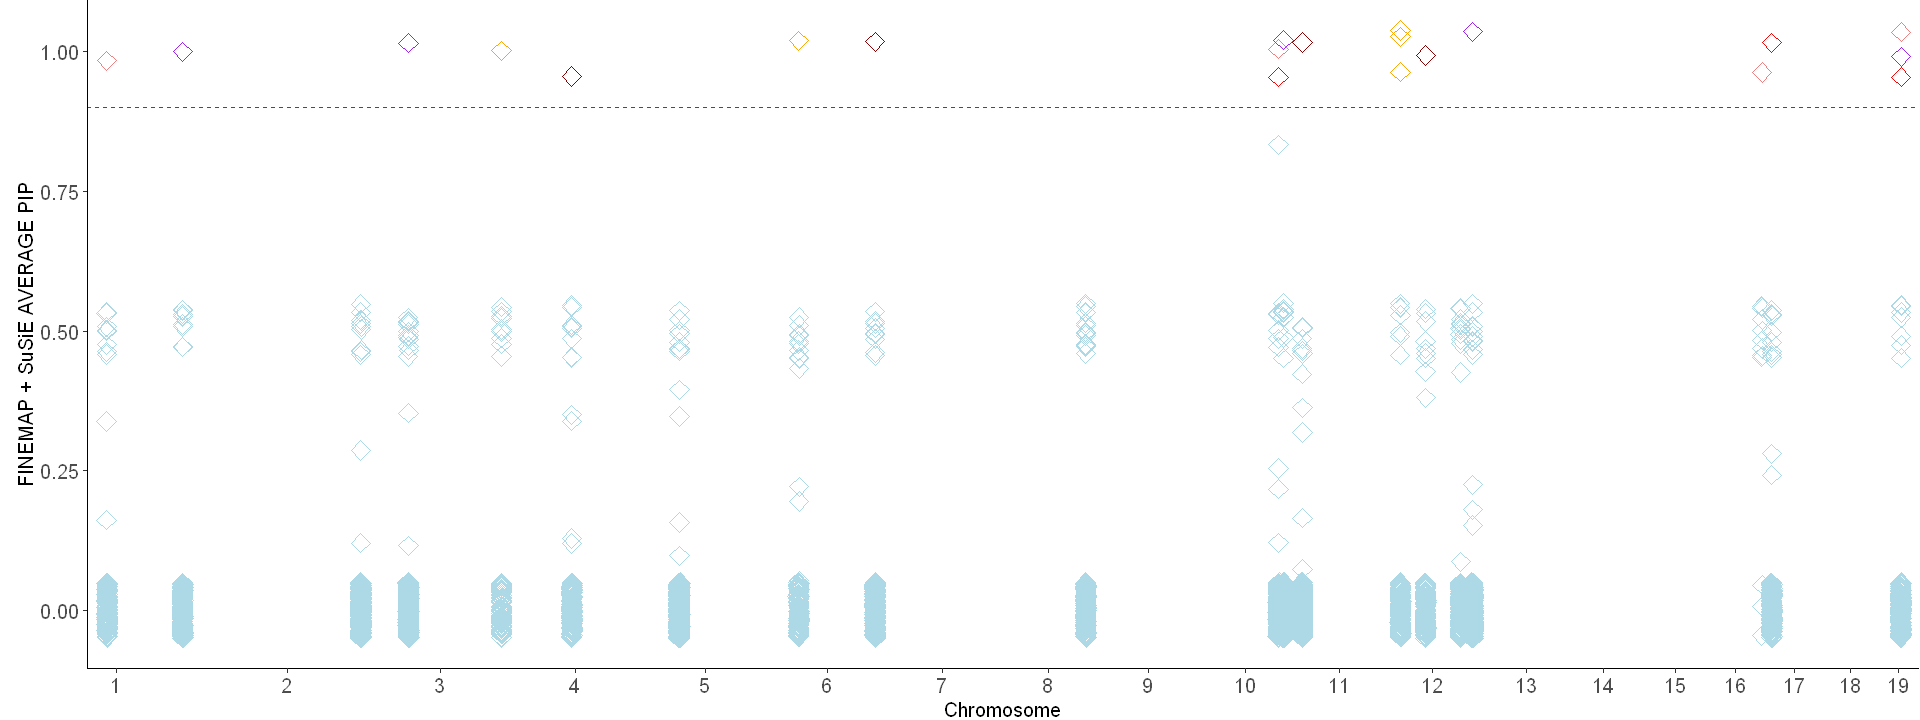

In [20]:
library('ggpubr')
options(repr.plot.width=16, repr.plot.height=6)
#b = c(0,0.20,0.60,0.8,0.9,1)
 p3 <- ggplot() + 
  geom_point(position=position_jitter(h=0.05, w=0.07),data =  plot_df, 
             aes(x = rel_pos, y = AVG_PIP,color=color),size=4,shape=23)+scale_color_manual(name=bquote("LD " ~r^2),values = c("ns"="lightblue","Index"="purple",
                                                                                                                "0.8-1"="darkred","0.6-0.8"="red","0.3-0.6"="lightcoral","0-0.3"="orange"))+
scale_x_continuous(labels = axis_df$CHROMOSOME, 
                     breaks = axis_df$chr_center, 
                     expand = expansion(mult = 0.01))+ 
#scale_y_sqrt(breaks=b,labels=b,limits = c(0,1),expand = expansion(mult = c(0.01, 0)))+
geom_hline(yintercept = 0.9, color = "red", linetype = "dashed", size = 0.3) + theme_classic() + theme( legend.position="bottom",plot.margin = margin(b = 0, l = 10))+
theme(axis.text=element_text(size=12),
        axis.title=element_text(size=12))+ theme(legend.text=element_text(size=14))
p5<- p3+labs(x = "Chromosome", y ='FINEMAP + SuSiE AVERAGE PIP')
legend <- get_legend(p5)
p6 <- p5 +theme(legend.position="none")
p6

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name              grob
1 1 (1-1,1-1) arrange    gtable[layout]
2 2 (2-2,1-1) arrange gtable[guide-box]

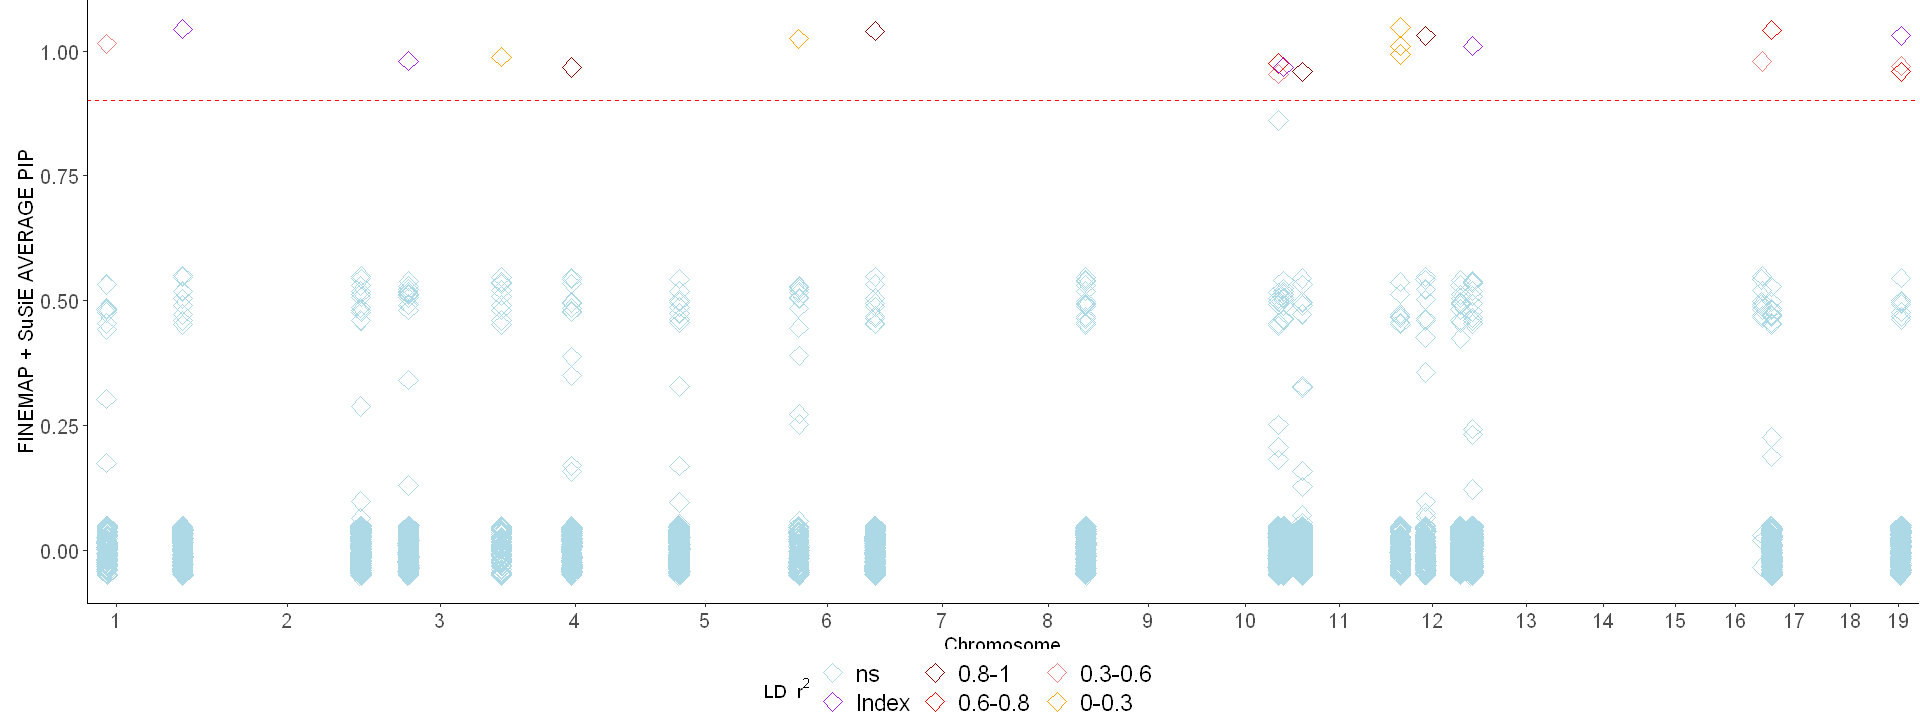

In [21]:
p <- gridExtra::grid.arrange(p6,legend,ncol=1,heights = c(0.1,0.01))
p
ggsave(filename = "../../ANALYSIS/PAPER/Figures/Fig3a.jpeg", device = "jpeg",  plot = p, width = 12, height =9 , dpi = 1200, units = "in")

In [22]:
casual_db <- read.table("../../ANALYSIS/PAPER/Figures/Main/causal_db_annotation.txt",header=T)
trait_mapping <- read.table("../../ANALYSIS/PAPER/Figures/Main/trait_mapping_causaldb.txt",header=T)
snp_pos <- read.table("../../ANALYSIS/PAPER/Figures/Main/sn_pos_mapping.txt",header=T)

In [23]:
db <- merge(casual_db,trait_mapping,by="TRAIT")
cdb <- merge(db,snp_pos,by="CAUSALSNP")

In [29]:
plot_df <- suppressWarnings(cdb%>%group_by(CTRAIT)%>% mutate(count = n())%>%filter(count>=2)%>%select(POS,CTRAIT,PVALUE,CHR)%>%group_by(POS,CTRAIT)%>%
mutate(ncount = n())%>%mutate(logp=case_when(ncount>1 ~ as.double(allmetap(as.double(PVALUE),method="sumz")$p)))%>%mutate(logp = coalesce(logp,PVALUE))%>%mutate(logp=-log10(logp)))%>%
ungroup()%>%mutate(logp= as.numeric(ifelse(is.finite(logp), logp, "300")))


In [30]:
head(plot_df)

POS,CTRAIT,PVALUE,CHR,ncount,logp
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
11:14701576,Lipids_Hormones,6.75e-42,11,2,240.31741
11:14701576,Body_size,5.02e-07,11,12,80.53537
11:14701576,Body_size,3.83e-10,11,12,80.53537
11:14701576,Body_size,6.08e-13,11,12,80.53537
11:14701576,Body_size,8.93e-07,11,12,80.53537
11:14701576,Body_composition,1.23e-09,11,15,113.01045


In [26]:
#plot_df <- suppressWarnings(cdb%>%group_by(TRAIT)%>% mutate(count = n())%>%filter(count>=2)%>%select(POS,TRAIT,PVALUE,CHR)%>%group_by(POS,TRAIT)%>%mutate(logp=-log10(PVALUE)))%>%
#mutate(logp= ifelse(is.finite(logp), logp, "300"))

In [31]:
head(plot_df)

POS,CTRAIT,PVALUE,CHR,ncount,logp
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
11:14701576,Lipids_Hormones,6.75e-42,11,2,240.31741
11:14701576,Body_size,5.02e-07,11,12,80.53537
11:14701576,Body_size,3.83e-10,11,12,80.53537
11:14701576,Body_size,6.08e-13,11,12,80.53537
11:14701576,Body_size,8.93e-07,11,12,80.53537
11:14701576,Body_composition,1.23e-09,11,15,113.01045


In [28]:
options(repr.plot.width=30, repr.plot.height=8)
p8 <- ggplot(plot_df, aes(x = POS, y = fct_rev(TRAIT), fill = logp)) +
  geom_tile()    +
  scale_fill_gradientn(colors = coul) + scale_y_discrete(labels=function(x) gsub("_", " ", x, fixed=TRUE))+
  coord_fixed()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+guides(fill = guide_colourbar(barwidth = 0.5,
                                barheight = 20))+theme(axis.text = element_text(size=12))+
                                                                              theme(axis.text.x = element_text(size = 15))+ theme(axis.text.y= element_text(size = 12))+
                                                         aes(x = fct_reorder(POS, CHR))+xlab("Causal SNP (AVG PIP > 0.9)")+ylab("CAUSALdb TRAIT")+coord_flip()

ERROR: Error in scale_fill_gradientn(colors = coul): object 'coul' not found


In [ ]:
ggsave(filename = "../../ANALYSIS/PAPER/Figures/Supplementary//SuppFig5.pdf", device = "pdf",  plot = p8, width = 30, height =20 , dpi = 1200, units = "in")

In [32]:
library(RColorBrewer)

In [33]:
coul <- brewer.pal(n = 9, name = "Reds")
coul <- colorRampPalette(coul)(25)

In [34]:
head(plot_df,2)

POS,CTRAIT,PVALUE,CHR,ncount,logp
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
11:14701576,Lipids_Hormones,6.75e-42,11,2,240.31741
11:14701576,Body_size,5.02e-07,11,12,80.53537


In [35]:
coul

[1] "#FFF5F0" "#FEEEE6" "#FEE7DB" "#FEE0D2" "#FDD3C1" "#FCC7B1" "#FCBBA1"
 [8] "#FCAD91" "#FC9F81" "#FC9272" "#FB8464" "#FB7757" "#FB6A4A" "#F75A40"
[15] "#F34A36" "#EF3B2C" "#E32F27" "#D72322" "#CB181D" "#BE151A" "#B11217"
[22] "#A50F15" "#900A12" "#7B050F" "#67000D"

In [46]:
options(repr.plot.width=16, repr.plot.height=9)
p4 <- ggplot(plot_df, aes(x = POS, y = fct_rev(CTRAIT), fill = logp)) +
  geom_tile()    +
  scale_fill_gradientn(colors = coul) + scale_y_discrete(labels=function(x) gsub("_", " ", x, fixed=TRUE))+
  coord_fixed()+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+guides(fill = guide_colourbar(barwidth = 0.5,
                                barheight = 20))+theme(axis.text = element_text(size=22))+
                                                                              theme(axis.text.x = element_text(size = 22))+ theme(axis.text.y= element_text(size = 20))+
                                                         aes(x = fct_reorder(POS, CHR))+xlab("")+ylab("")

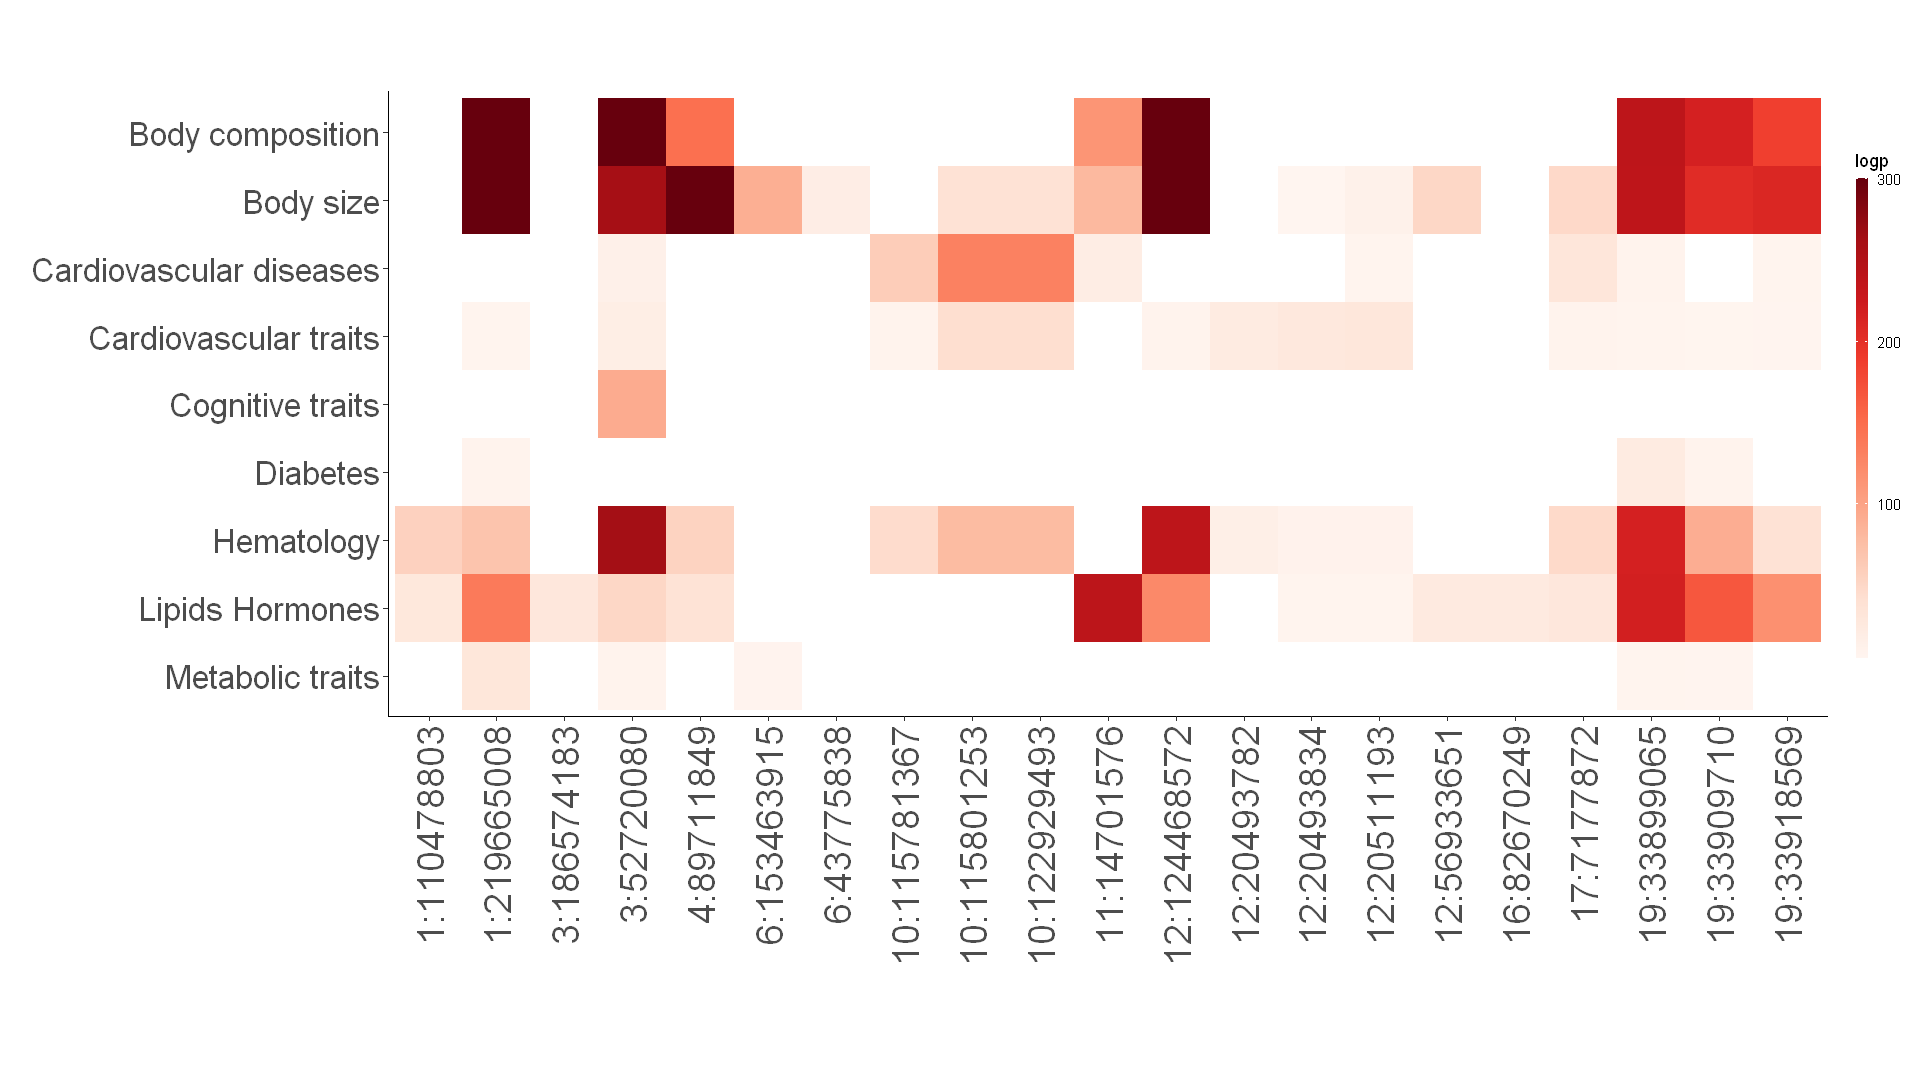

In [47]:
p4

In [48]:
ggsave(filename = "../../ANALYSIS/PAPER/Figures/Fig3b.jpeg", device = "jpeg",  plot = p4, width = 16, height =9 , dpi = 600, units = "in")

In [67]:
#combine

TableGrob (2 x 2) "arrange": 3 grobs
  z     cells    name              grob
1 1 (1-1,1-1) arrange    gtable[layout]
2 2 (1-1,2-2) arrange    gtable[layout]
3 3 (2-2,1-1) arrange gtable[guide-box]

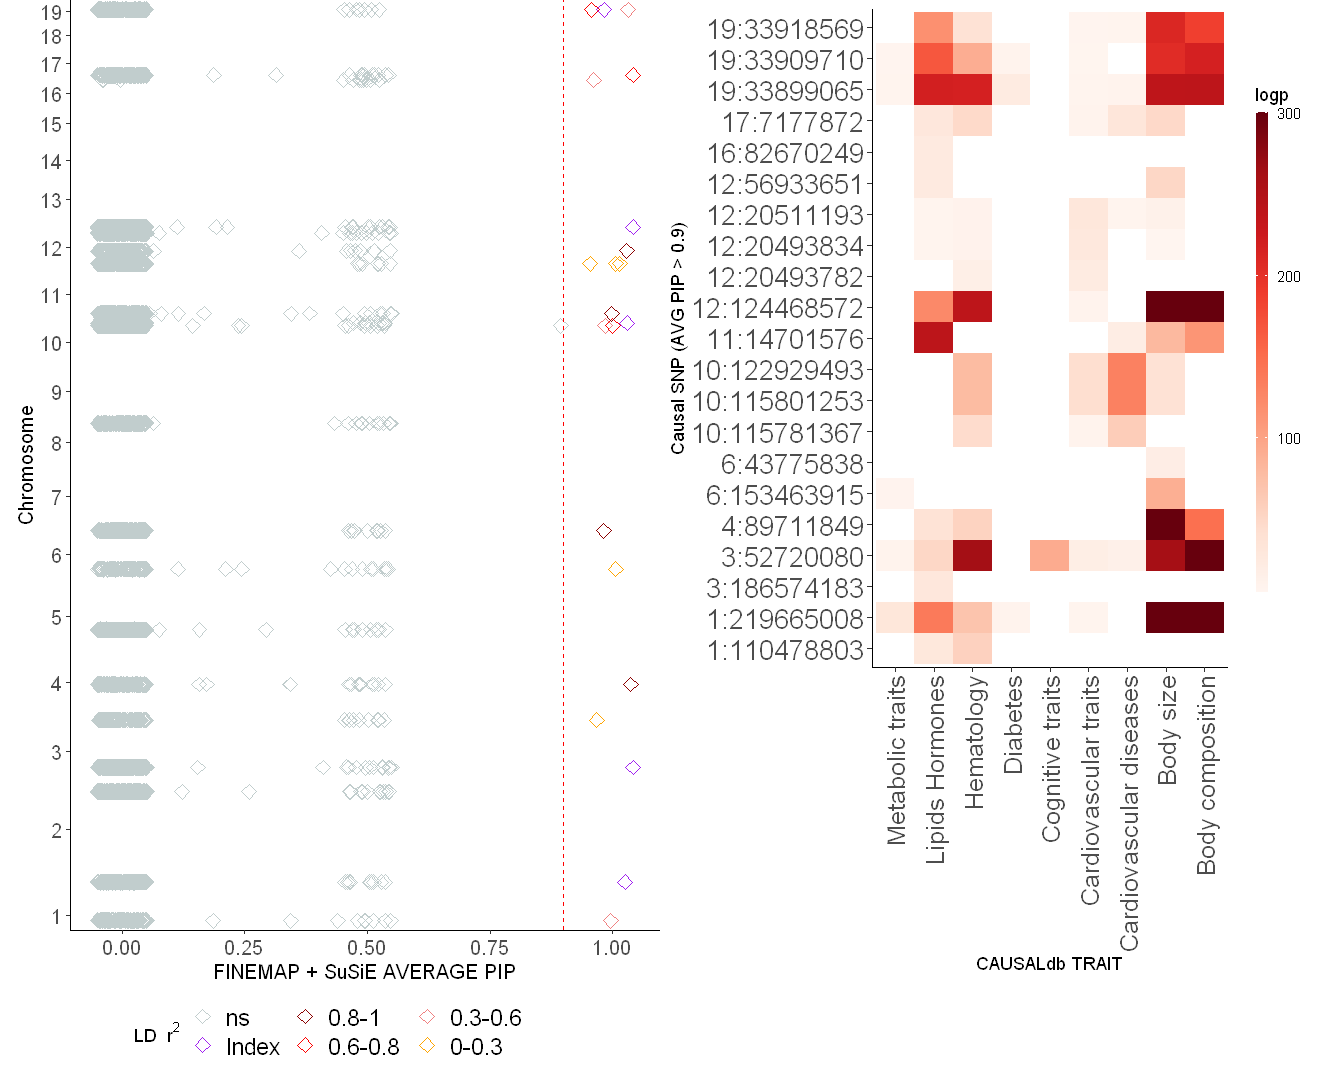

In [139]:
options(repr.plot.width=16, repr.plot.height=9)
p <- gridExtra::grid.arrange(p6,p4,legend,ncol=2,heights = c(0.1,0.01),widths= c(0.6,0.6))
p
ggsave(filename = "../../ANALYSIS/PAPER/Figures/Fig3.jpeg", device = "jpeg",  plot = p, width = 12, height =9 , dpi = 00, units = "in")

In [255]:
##############

In [256]:
result_df <- merge(finemap,susie,by="MARKERNAME")%>%mutate(AVG_PIP=(FINEMAP_PIP+SUSIE_PIP)/2)
final_df <- merge(META_THREE,result_df,by="MARKERNAME")
Metasoft_results <-  read.table("../../ANALYSIS/META/METASOFT/SECOND_PASS/TRANSANCESTRY_METASOFT_SECONDPASS_RESULTS.TAB",fill=TRUE,row.names=NULL,header=FALSE)
colnames(Metasoft_results) <- c("MARKERNAME","N","PVALUE_FE","BETA_FE","STD_FE","PVALUE_RE","BETA_RE","STD_RE","PVALUE_RE2","STAT1_RE2","STAT2_RE2","PVALUE_BE","I_SQUARE","Q","PVALUE_Q","TAU_SQUARE",
                                "PVALUE_ADIPOGEN","PVALUE_AGEN","PVALUE_METSIM","NA1","NA2","NA3")
final_df_2 <- merge(final_df,Metasoft_results)%>%select(MARKERNAME,CHROMOSOME,POSITION,PVALUE_FE,AVG_PIP,FINEMAP_PIP,SUSIE_PIP)

In [147]:
final_df_3 <- final_df_2%>%select(MARKERNAME,PVALUE_FE,AVG_PIP,FINEMAP_PIP,SUSIE_PIP)%>%mutate(shape=case_when(AVG_PIP > 0.9 ~"23",AVG_PIP > 0.4 & AVG_PIP < 0.9 ~"3",TRUE ~ "1"))%>%
mutate(size=case_when(AVG_PIP > 0.9 ~"0.7",TRUE ~ "0.4"))%>%
mutate(alpha=case_when(AVG_PIP > 0.9 ~"0.9",AVG_PIP > 0.4 & AVG_PIP < 0.9 ~"0.7",TRUE ~ "0.4"))
final_df_4_annot <- read.table("../../ANALYSIS/finemap_annotation.txt",header=TRUE,fill=TRUE,row.names=NULL)
final_df_4 <- merge(final_df_3,final_df_4_annot,by="MARKERNAME",all.x=TRUE)%>%
mutate(color=case_when(LD > 0.9 ~"ssig",LD > 0.7 & LD <=0.9 ~"sig",LD > 0.4 & LD<=0.7 ~"ig",LD>0.2 & LD<=0.4 ~"g",TRUE ~ "ns"))


In [148]:
final_df_4%>%filter(LD!="NA")

MARKERNAME,PVALUE_FE,AVG_PIP,FINEMAP_PIP,SUSIE_PIP,shape,size,alpha,LD,Annotation,color
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
rs10128681,3.43227e-07,1.0000000,1.000000,1.0000000,23,0.7,0.9,0.995,PDE3B,ssig
rs1063538,3.61435e-39,1.0000000,1.000000,1.0000000,23,0.7,0.9,0.085,ADIPOQ,ns
rs10770642,6.35631e-08,1.0000000,1.000000,1.0000000,23,0.7,0.9,0.152,PDE3A,ns
rs10770643,5.77124e-11,1.0000000,1.000000,1.0000000,23,0.7,0.9,0.254,,g
rs10886863,1.80274e-12,1.0000000,1.000000,1.0000000,23,0.7,0.9,1.000,RP11,ssig
rs1108842,7.04011e-16,1.0000000,1.000000,1.0000000,23,0.7,0.9,1.000,GNL3,ssig
rs16957913,3.21273e-85,1.0000000,1.000000,1.0000000,23,0.7,0.9,0.472,CDH13,ig
rs2009084,1.27575e-10,1.0000000,1.000000,1.0000000,23,0.7,0.9,0.219,,g
rs2061155,5.33629e-09,1.0000000,1.000000,1.0000000,23,0.7,0.9,1.000,LYPAL1-AS1,ssig


Warning message:
"Using size for a discrete variable is not advised."
Warning message:
"Using alpha for a discrete variable is not advised."
Warning message:
"Removed 2881 rows containing missing values (geom_point)."


png 
  2

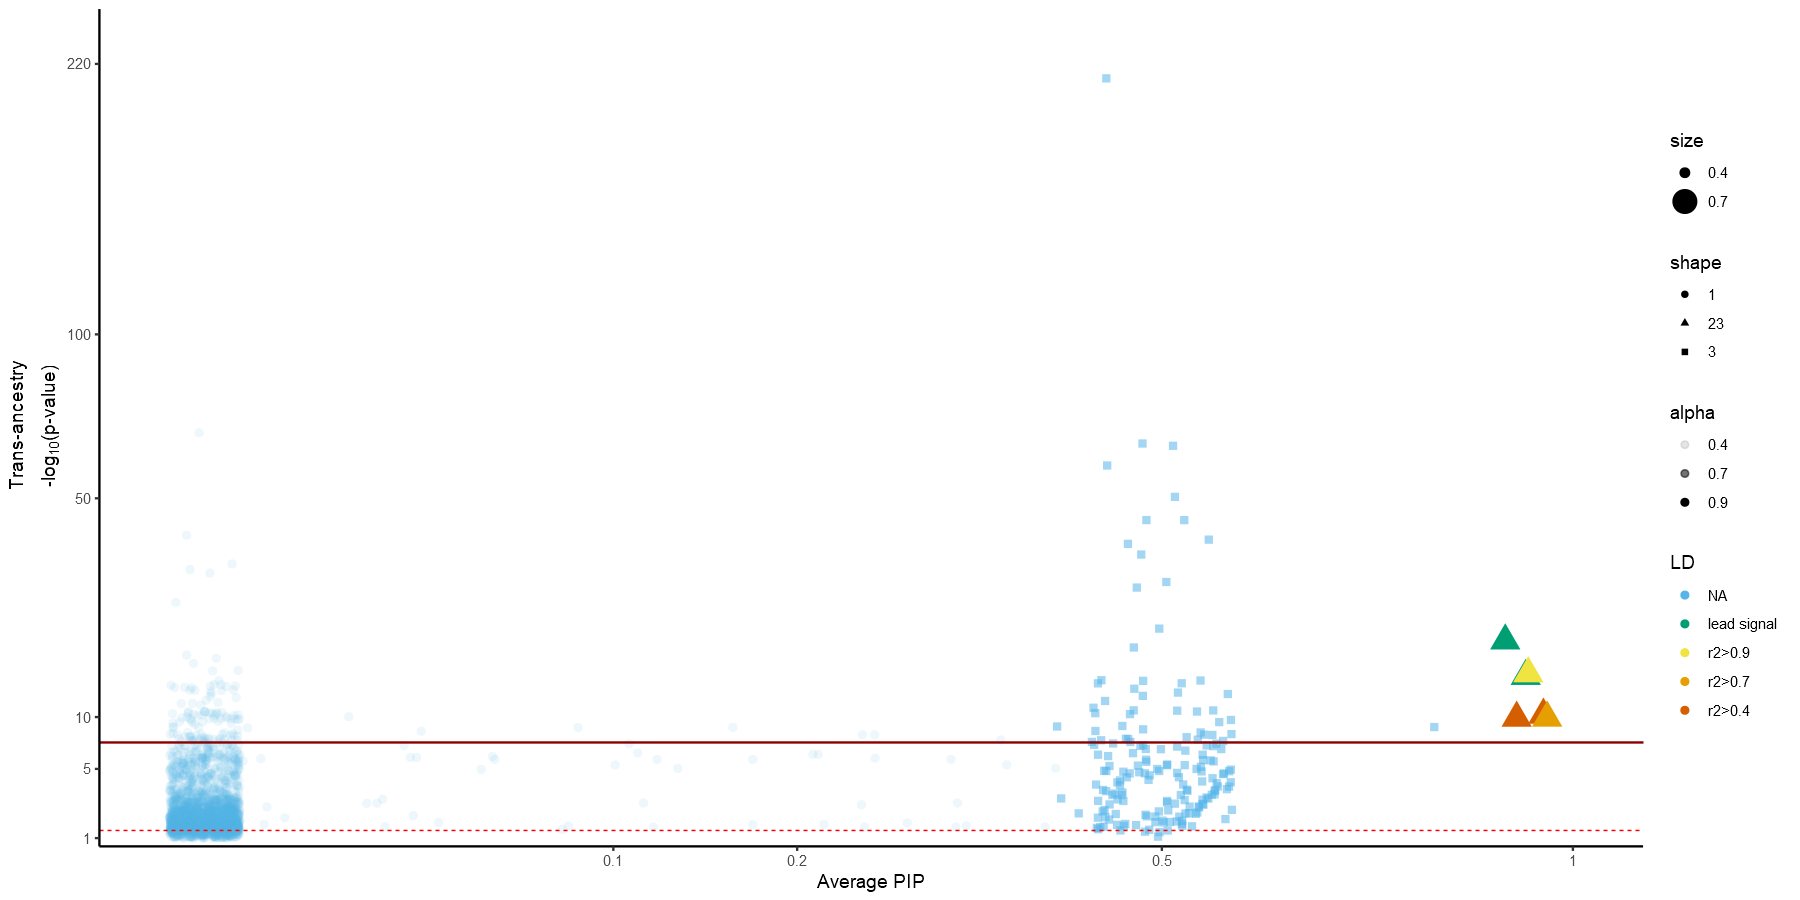

In [155]:
b = c(1,5,10,50,100,220)
c=c(0,0.1,0.2,0.5,1)
p <- final_df_4 %>%ggplot() + 
geom_point(aes(x = AVG_PIP , y =-log10(PVALUE_FE) ,color=color,shape=shape,size=size,alpha=alpha),position = position_jitter(w = 0.05, h = 0))+scale_color_manual(name="LD",
labels = c("NA","lead signal", "r2>0.9","r2>0.7","r2>0.4","r2>0.2"),values = c("ns" = "#56B4E9","ssig"="#009E73","sig" = "#F0E442","ig"="#E69F00","g" = "#D55E00"))+
scale_y_sqrt(breaks=b,labels=b,limits = c(1, 250),expand = expansion(mult = c(0.01, 0)))+ geom_hline(yintercept = -log10(5e-2), color = "red", linetype = "dashed", size = 0.3) +
  geom_hline(yintercept = -log10(5e-8), color = "darkred", linetype = "solid", size = 0.5)+labs(x = "Average PIP", y = bquote(atop('Trans-ancestry', '-log'[10]*'(p-value)'))) + theme_classic()+
scale_x_sqrt(breaks=c,labels=c,limits = c(0, 1))
p
jpeg("test.jpeg", units="in", width=10, height=5, res=600)
dev.off()

Warning message:
"Removed 172 rows containing missing values (geom_point)."


ERROR: [1m[33mError[39m:[22m
[33m![39m Cannot use `+.gg()` with a single argument. Did you accidentally put + on a new line?


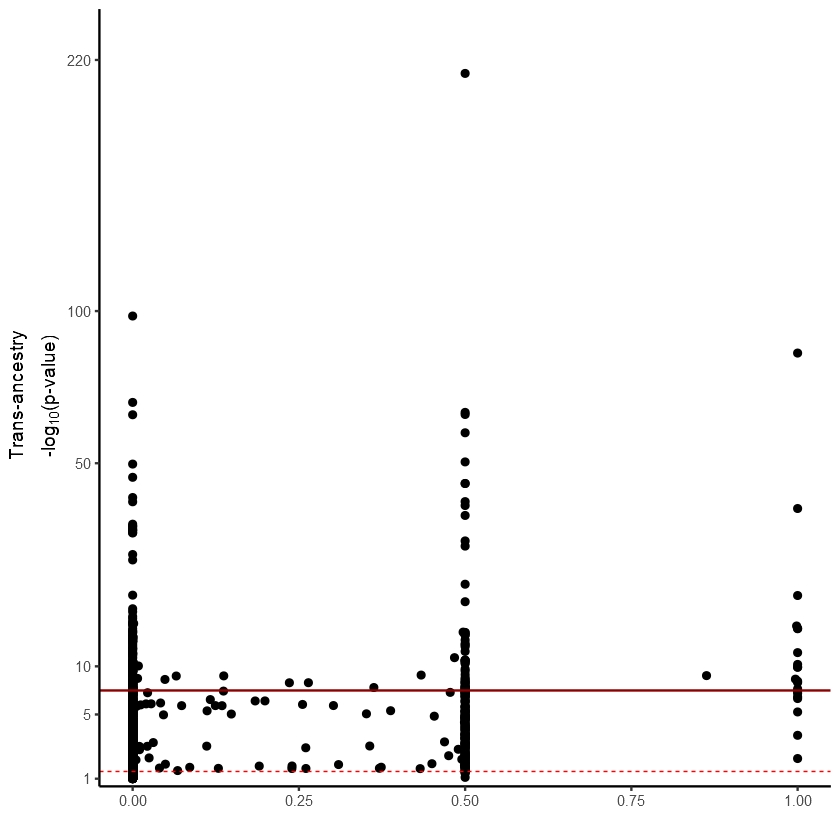

In [85]:

final_df_3 %>%ggplot() + geom_point(aes(x = AVG_PIP , y =-log10(PVALUE_FE) ))+scale_y_sqrt(breaks=b,labels=b,limits = c(1, 250),expand = expansion(mult = c(0.01, 0)))+ geom_hline(yintercept = -log10(5e-02), 
  color = "red", linetype = "dashed", size = 0.3)+geom_hline(yintercept = -log10(5e-8), color = "darkred", linetype = "solid", size = 0.5)+labs(x = "", y = bquote(atop('Trans-ancestry', '-log'[10]*'(p-value)'))) + theme_classic() 
+ theme(legend.position = "none", axis.title.x = element_blank(),plot.margin = margin(b = 0, l = 10))+theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))

In [68]:
final_df_2%>%group_by(CHROMOSOME)%>%filter(AVG_PIP>0.90)

MARKERNAME,CHROMOSOME,POSITION,PVALUE_FE,AVG_PIP,FINEMAP_PIP,SUSIE_PIP
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
rs10128681,11,14701576,3.43227e-07,1.0000000,1.000000,1.0000000
rs1063538,3,186574183,3.61435e-39,1.0000000,1.000000,1.0000000
rs10770642,12,20493782,6.35631e-08,1.0000000,1.000000,1.0000000
rs10770643,12,20493834,5.77124e-11,1.0000000,1.000000,1.0000000
rs10886863,10,122929493,1.80274e-12,1.0000000,1.000000,1.0000000
rs1108842,3,52720080,7.04011e-16,1.0000000,1.000000,1.0000000
rs16957913,16,82670249,3.21273e-85,1.0000000,1.000000,1.0000000
rs2009084,12,20511193,1.27575e-10,1.0000000,1.000000,1.0000000
rs2061155,1,219665008,5.33629e-09,1.0000000,1.000000,1.0000000


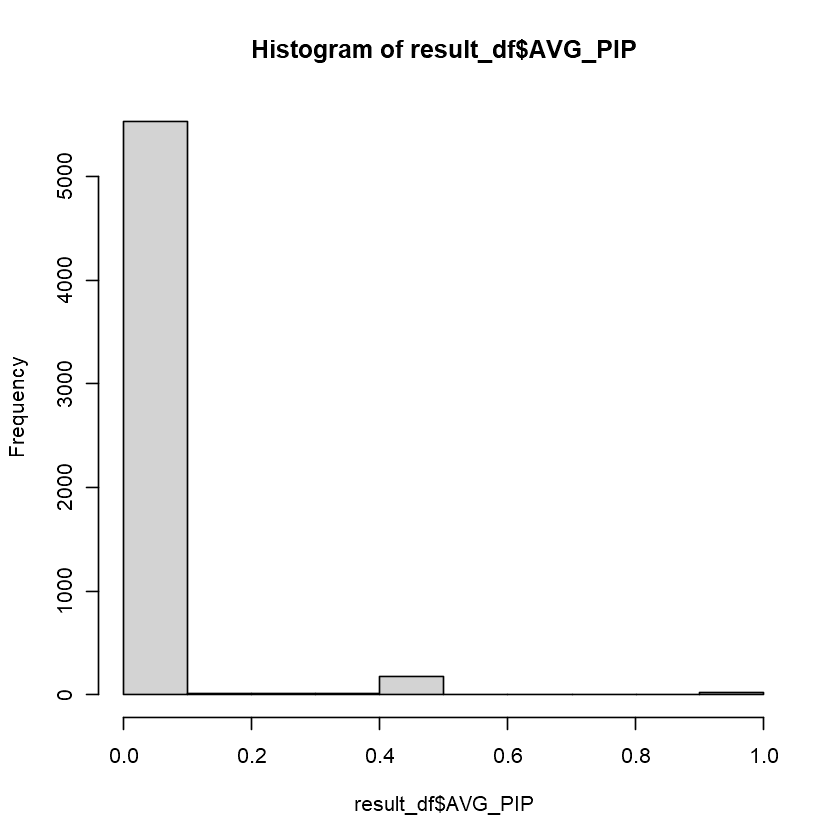

In [7]:
hist(result_df$AVG_PIP)

In [42]:
result_df <- merge(finemap,susie,by="MARKERNAME")%>%mutate(AVG_PIP=(FINEMAP_PIP+SUSIE_PIP)/2)%>%filter(AVG_PIP>0.9)

In [43]:
final_df <- merge(META_THREE,result_df,by="MARKERNAME")

In [47]:
Metasoft_results <-  read.table("../../ANALYSIS/META/METASOFT/SECOND_PASS/TRANSANCESTRY_METASOFT_SECONDPASS_RESULTS.TAB",fill=TRUE,row.names=NULL,header=FALSE)
colnames(Metasoft_results) <- c("MARKERNAME","N","PVALUE_FE","BETA_FE","STD_FE","PVALUE_RE","BETA_RE","STD_RE","PVALUE_RE2","STAT1_RE2","STAT2_RE2","PVALUE_BE","I_SQUARE","Q","PVALUE_Q","TAU_SQUARE",
                                "PVALUE_ADIPOGEN","PVALUE_AGEN","PVALUE_METSIM","NA1","NA2","NA3")

In [51]:
colnames(merge(final_df,Metasoft_results))

[1] "MARKERNAME"      "CHROMOSOME"      "POSITION"        "ADIPO_EA"       
 [5] "ADIPO_NEA"       "ADIPO_EAF"       "ADIPO_N"         "ADIPO_BETA"     
 [9] "ADIPO_SE"        "ADIPO_PVALUE"    "AGEN_EA"         "AGEN_NEA"       
[13] "AGEN_EAF"        "AGEN_N"          "AGEN_BETA"       "AGEN_SE"        
[17] "AGEN_PVALUE"     "METSIM_EA"       "METSIM_NEA"      "METSIM_EAF"     
[21] "METSIM_N"        "METSIM_BETA"     "METSIM_SE"       "METSIM_PVALUE"  
[25] "FINEMAP_PIP"     "SUSIE_PIP"       "AVG_PIP"         "N"              
[29] "PVALUE_FE"       "BETA_FE"         "STD_FE"          "PVALUE_RE"      
[33] "BETA_RE"         "STD_RE"          "PVALUE_RE2"      "STAT1_RE2"      
[37] "STAT2_RE2"       "PVALUE_BE"       "I_SQUARE"        "Q"              
[41] "PVALUE_Q"        "TAU_SQUARE"      "PVALUE_ADIPOGEN" "PVALUE_AGEN"    
[45] "PVALUE_METSIM"   "NA1"             "NA2"             "NA3"

In [54]:
final_df_2 <- merge(final_df,Metasoft_results)%>%select(MARKERNAME,CHROMOSOME,POSITION,METSIM_EA,METSIM_NEA,ADIPO_EAF,AGEN_EAF,METSIM_EAF,FINEMAP_PIP,SUSIE_PIP,AVG_PIP,N,PVALUE_FE,BETA_FE,STD_FE)
write.table(final_df_2,"../../ANALYSIS/FINEMAP/TRANS_FINEMAPING.tab",row.names=FALSE,quote=FALSE,sep="\t")

In [28]:
### EUR

In [55]:
META_TWO <- read.table(gzfile("../data/EUR_GWAS.TAB.gz"),header=T,fill=TRUE,row.names=NULL)

In [56]:
finemap <- read.table("../../ANALYSIS//FINEMAP/EUR_FINEMAP_PIP.tab",fill=TRUE,row.names=NULL,header=FALSE)
colnames(finemap) <- c("MARKERNAME","FINEMAP_PIP")
susie <- read.table("../../ANALYSIS/SUSIE//eur_susie_pip.tab",fill=TRUE,row.names=NULL,header=TRUE)

In [57]:
result_df <- merge(finemap,susie,by="MARKERNAME")%>%mutate(AVG_PIP=(FINEMAP_PIP+SUSIE_PIP)/2)%>%filter(AVG_PIP>0.9)

In [59]:
final_df <- merge(META_TWO,result_df,by="MARKERNAME")

In [60]:
Metasoft_results <-  read.table("../../ANALYSIS/META/METASOFT/SECOND_PASS/EUROPEAN_METASOFT_SECONDPASS_RESULTS.TAB",fill=TRUE,row.names=NULL,header=FALSE)
colnames(Metasoft_results) <- c("MARKERNAME","N","PVALUE_FE","BETA_FE","STD_FE","PVALUE_RE","BETA_RE","STD_RE","PVALUE_RE2","STAT1_RE2","STAT2_RE2","PVALUE_BE","I_SQUARE","Q","PVALUE_Q","TAU_SQUARE",
                                "PVALUE_ADIPOGEN","PVALUE_METSIM","NA1","NA2")

In [62]:
final_df_2 <- merge(final_df,Metasoft_results)%>%select(MARKERNAME,CHROMOSOME.x,POSITION.x,METSIM_EA,METSIM_NEA,ADIPO_EAF,METSIM_EAF,FINEMAP_PIP,SUSIE_PIP,AVG_PIP,N,PVALUE_FE,BETA_FE,STD_FE)
write.table(final_df_2,"../../ANALYSIS/FINEMAP/EUR_FINEMAPING.tab",row.names=FALSE,quote=FALSE,sep="\t")

In [ ]:
ggsave(filename = "../../ANALYSIS/PAPER/Figures/Fig3.pdf", device = "pdf",  plot = p, width = 15, height =12 , dpi = 1200, units = "in")